In [1]:
import numpy as np

train_images_data = np.load('./input/train_images.npy', encoding = 'latin1')
train_labels_data = np.genfromtxt('./input/train_labels.csv', names=True, delimiter=',',
                        dtype=[('Id', 'i8'), ('Category', 'S16')])

In [2]:
# debug(train_images_data.shape, train_labels_data.shape)
sample_size = train_images_data.shape[0]
sample_features = len(train_images_data[0][1])

train_images = np.vstack(train_images_data[:, 1])
train_labels = np.zeros((sample_size, ), dtype = np.long)

label_to_int, int_to_label = {}, {}

label_i = 0 # first label index
for i, train_label in train_labels_data:
    train_label = train_label.decode("utf-8")
    if label_to_int.get(train_label) is None:
        label_to_int[train_label] = label_i
        train_labels[i] = label_i
        label_i += 1
    else:
        train_labels[i] = label_to_int[train_label]
        
for key, value in label_to_int.items():
    int_to_label[value] = key   
    
print(int_to_label)
print(label_to_int)
print(train_images.shape, train_labels.shape)

n_class = len(int_to_label)
print("number of class = ", n_class)

{0: 'shovel', 1: 'rifle', 2: 'scorpion', 3: 'apple', 4: 'spoon', 5: 'pineapple', 6: 'mouth', 7: 'skateboard', 8: 'rollerskates', 9: 'peanut', 10: 'rabbit', 11: 'sink', 12: 'sailboat', 13: 'nose', 14: 'skull', 15: 'pool', 16: 'pear', 17: 'pillow', 18: 'penguin', 19: 'nail', 20: 'pencil', 21: 'empty', 22: 'octagon', 23: 'moustache', 24: 'paintbrush', 25: 'panda', 26: 'parrot', 27: 'screwdriver', 28: 'squiggle', 29: 'rhinoceros', 30: 'mug'}
{'shovel': 0, 'rifle': 1, 'scorpion': 2, 'apple': 3, 'spoon': 4, 'pineapple': 5, 'mouth': 6, 'skateboard': 7, 'rollerskates': 8, 'peanut': 9, 'rabbit': 10, 'sink': 11, 'sailboat': 12, 'nose': 13, 'skull': 14, 'pool': 15, 'pear': 16, 'pillow': 17, 'penguin': 18, 'nail': 19, 'pencil': 20, 'empty': 21, 'octagon': 22, 'moustache': 23, 'paintbrush': 24, 'panda': 25, 'parrot': 26, 'screwdriver': 27, 'squiggle': 28, 'rhinoceros': 29, 'mug': 30}
(10000, 10000) (10000,)
number of class =  31


## Noise Reduction

In [3]:
class DFS: 
    def __init__(self, my_shape, matrix): 
        self.row = my_shape[0]
        self.col = my_shape[1]
        self.matrix = matrix
        
    def is_safe(self, i, j, visited): 
        return (i >= 0 and i < self.row and 
                j >= 0 and j < self.col and 
                not visited[i, j] and self.matrix[i, j] > 0)
    
    def get_all_neighborhood(self, i, j, visited, points):
        """get all points connected to point [i, j]
        Params
            i, j: row and col index of a given point, int, int
            visited: mark whether a point is visited or not, narray
            points: connected neighbors of point [i, j],list
        Returns
            points: 
        """
        points.append((i, j))
        visited[i, j] = True
        nbrs_row = [-1, -1, -1,  0, 0,  1, 1, 1]; 
        nbrs_col = [-1,  0,  1, -1, 1, -1, 0, 1];   
        # Recur for all connected neighbours 
        for k in range(8): # max neighbor numbers
            if self.is_safe(i + nbrs_row[k], j + nbrs_col[k], visited): 
                self.get_all_neighborhood(i + nbrs_row[k], j + nbrs_col[k], visited, points)
        return points
    
    
def get_region_size(matrix, row, col):
    if row < 0 or col < 0 or row >= len(matrix) or col >= len(matrix[row]):
        return 0
    
    if matrix[row, col] == 0:
        return 0
    
    matrix[row, col] = 0 # avoid repeated counting
    size = 1
    for r in range(row - 1, row + 2):
        for c in range(col - 1, col + 2):
            if r != row or c != col:
                size += get_region_size(matrix, r, c)
    return size

def get_biggest_region(matrix, m_shape):
    max_region_size = 0
    rows, cols = m_shape
    x, y = 0, 0
    for r in range(rows):
        for c in range(cols):
            if matrix[r, c] > 0:
                size = get_region_size(matrix, r, c)
                if size > max_region_size:
                    x, y = r, c
                    max_region_size = size
    return max_region_size, x, y    

### reduce noise

In [4]:
def reduce_noise(X, img_size = (100, 100)):
    # some function (get_region_size) changes original data as parameters.
    X_copy = copy.deepcopy(X)
    for i, x in enumerate(X_copy):
        img = x.reshape(img_size)
        img_copy = copy.deepcopy(img)
        max_region_size, x, y = get_biggest_region(img_copy, img_size)
        m = DFS(img_size, img)
        visited = np.zeros(img_size)
        points = m.get_all_neighborhood(x, y, visited, [])

        img_target = np.zeros(old_img_size)
        for p in points:
            img_target[p[0], p[1]] = img[p[0], p[1]]
        X_copy[i] = img_target.reshape(-1, )
        print_progress(100 * (i+1)/len(X_copy))
    
    return X_copy

In [5]:
old_img_size = (100, 100)
file_train_X = './input/noise_reduced_train_X.npy'
# np.save(file_train_X, train_X)

try:
    print("trying loading noise reduced data from file...")
    train_X = np.load(file_train_X, encoding = 'latin1')
    print("successfully loaded.")
except:
    train_X = reduce_noise(train_images, img_size = old_img_size)
    np.save(file_train_X, train_X)
    print("saving train_X to file: {}".format(file_train_X))

print(train_X.shape)

trying loading noise reduced data from file...
successfully loaded.
(10000, 10000)


image id:1256, class_id:0, class:shovel


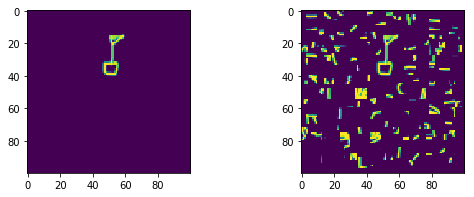

In [10]:
import matplotlib.pyplot as plt

def show_images(Xs, labels = None):
    Xs = list(Xs)
    n = len(Xs)
    plt.figure(figsize = (3*(n+1), 3))
    rdn = np.random.randint(0, Xs[0].shape[0])
    if labels is not None:
        print("image id:{}, class_id:{}, class:{}".format(
            rdn, labels[rdn], int_to_label[labels[rdn]]))
    else:
        print("id:{}".format(rdn))
    for i, X in enumerate(Xs):
        plt.subplot(1, n, i+1)
        size = int(np.sqrt(X.shape[1]))
        plt.imshow(X[rdn].reshape(size, size))
    plt.show()
        
show_images([train_X, train_images], train_labels)